# Kaggle test using basic solver

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import multiprocessing
from multiprocessing.pool import ThreadPool

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelBinarizer

import keras
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler

import cv2

import os

C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [96]:
# Load images
images = np.load('Datasets/train_images.npy', encoding="bytes")
labels = pd.read_csv('Datasets/train_labels.csv')
labels = labels['Category'].values
images.shape

(10000, 2)

In [112]:
def preProcessImage(image, num_contours =1, cutoff=127):
    image = np.uint8(image)
    im = np.uint8(image)
    red, thresh = cv2.threshold(im, cutoff, 255, 0)
    im2, contours, hierarchy= cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    mask = np.zeros(im.shape, np.uint8)
    largest_contours = sorted(contours, key=cv2.contourArea, reverse=True)

    for ind, contour in enumerate(largest_contours[:num_contours]):
        x, y, w, h = cv2.boundingRect(contour)
        mask[y:y+h, x:x+w] = 255
        
    filteredImage = cv2.bitwise_and(thresh, thresh, mask=mask)
    return filteredImage.reshape((image.shape))

C:\Users\Antonios\Anaconda3\envs\my_root\lib\site-packages\matplotlib\pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


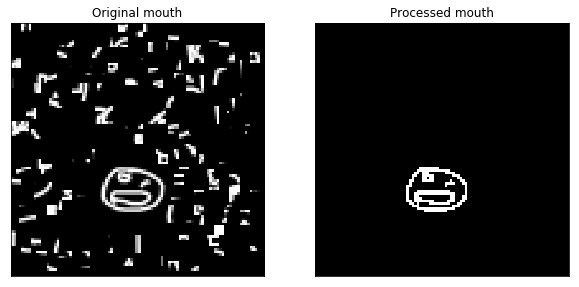

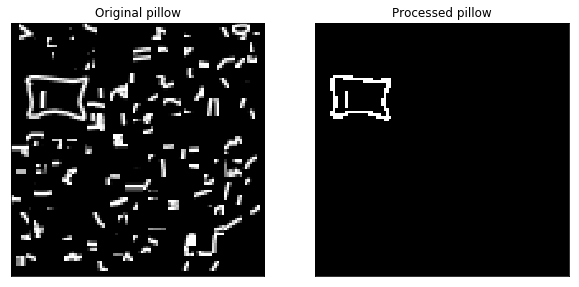

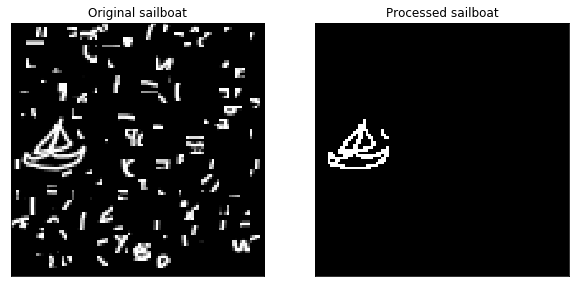

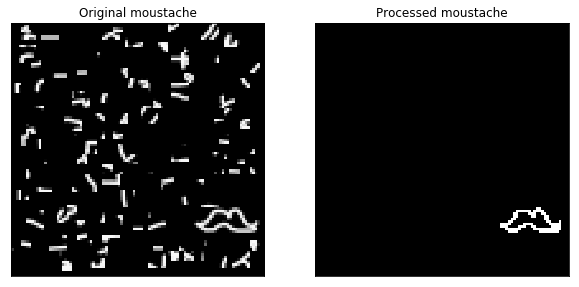

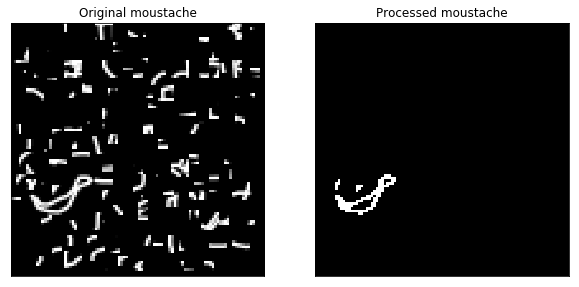

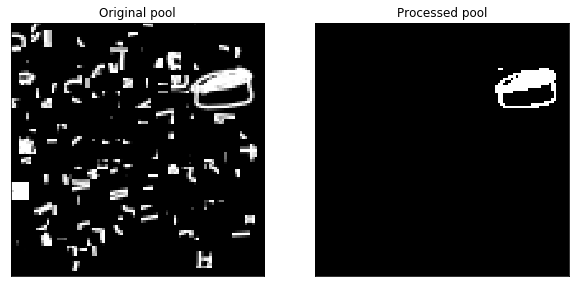

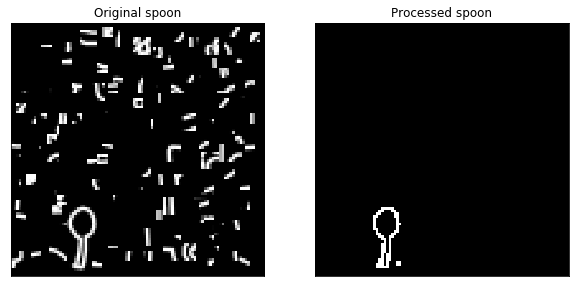

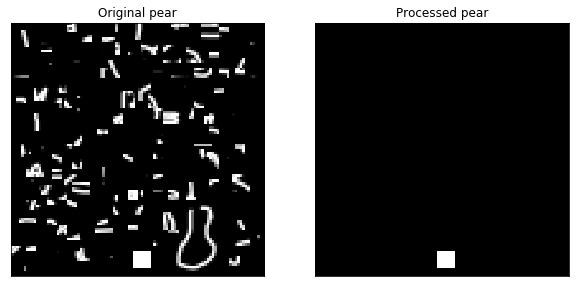

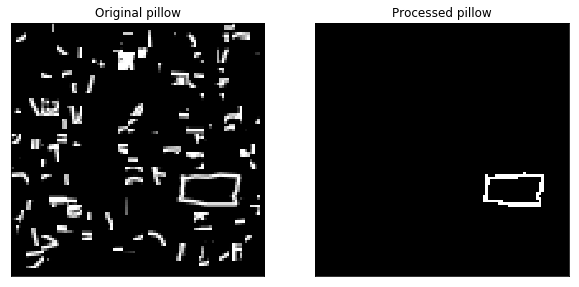

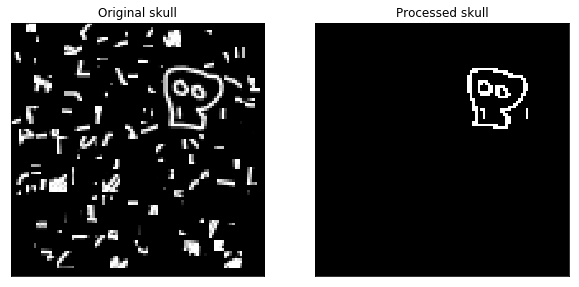

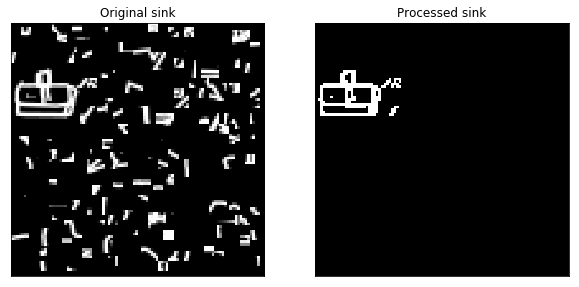

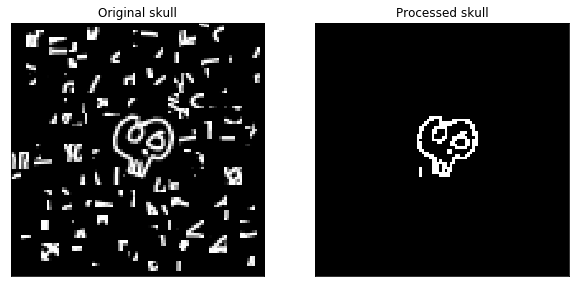

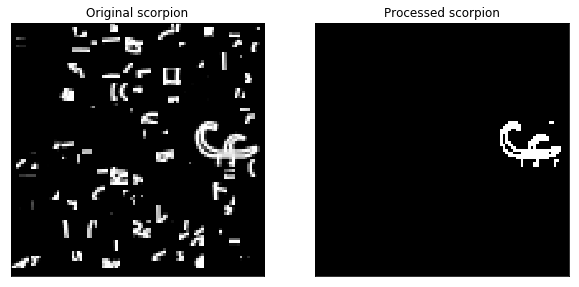

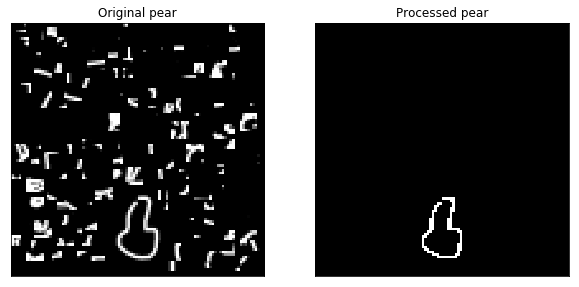

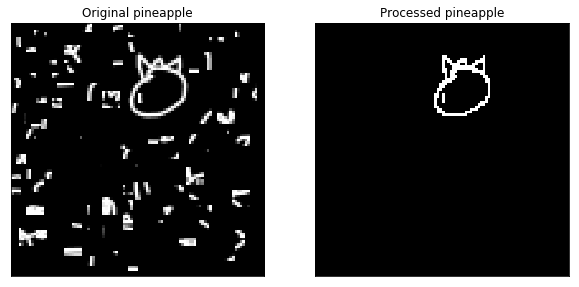

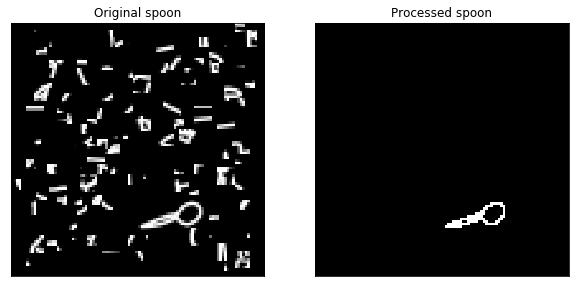

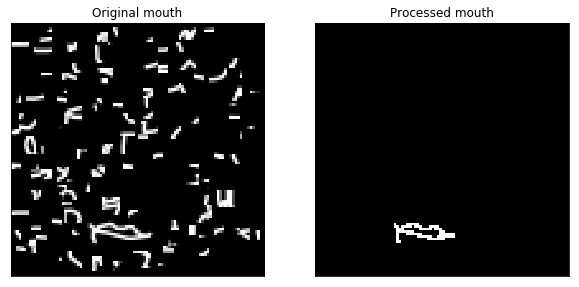

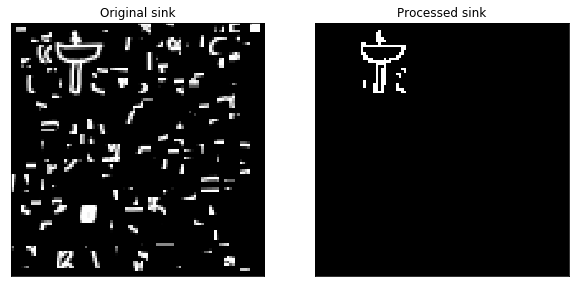

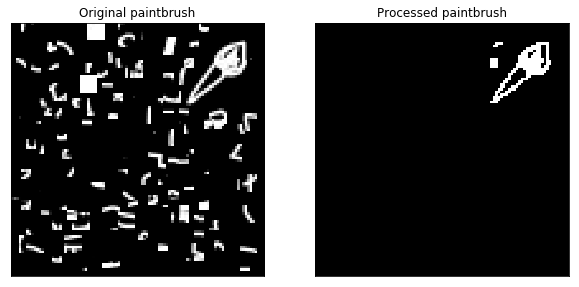

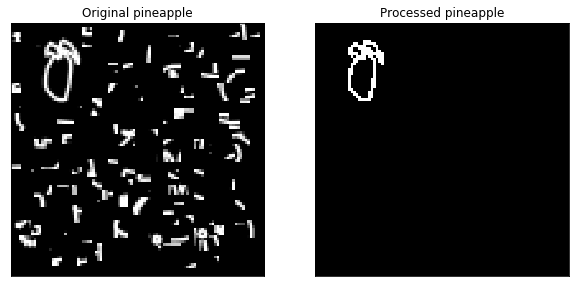

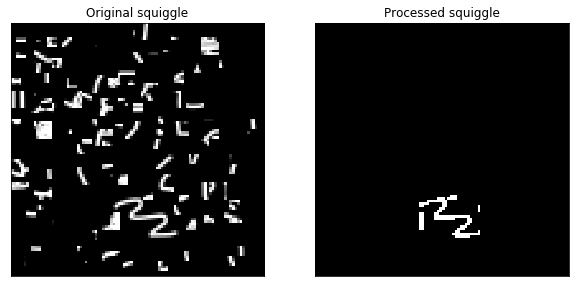

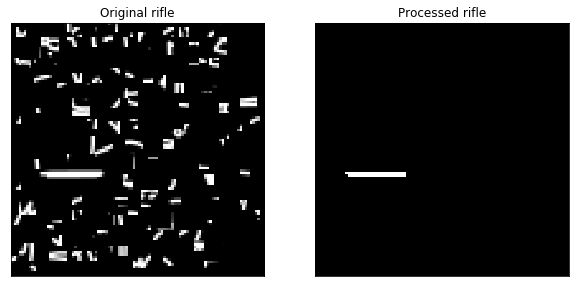

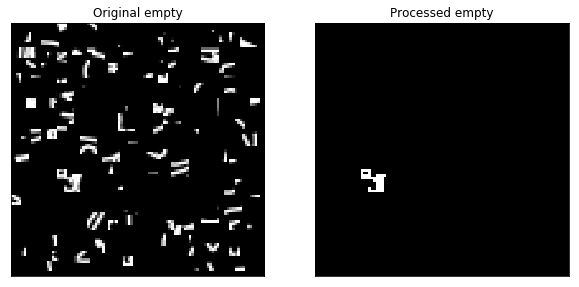

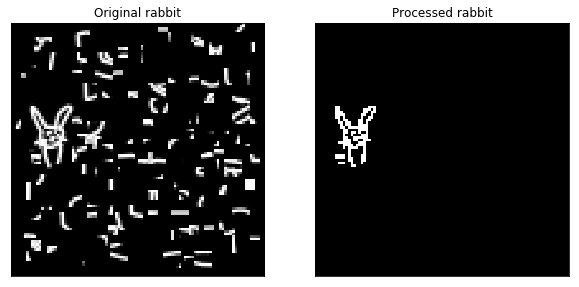

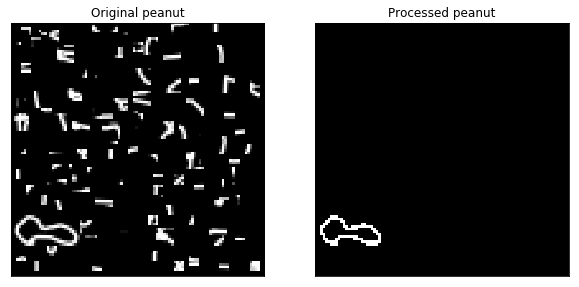

In [130]:
def show_before_and_after(img_num):
    plt.figure(figsize = (10,10))
    plt.subplot(121)
    image = images[img_num][1].reshape(100, 100)
    plt.title('Original {}'.format(labels[img_num]))
    plt.xticks([]), plt.yticks([])
    plt.imshow(image, cmap = 'gray')
    plt.subplot(122)
    plt.title('Processed {}'.format(labels[img_num]))
    filtered_image = preProcessImage(image)
    plt.xticks([]), plt.yticks([])
    plt.imshow(filtered_image, cmap = 'gray')
    
for k in range(1001,1026):
    show_before_and_after(k)

In [134]:
def get_box_size(img):
    data = np.uint8(img)
    x_min = 100
    y_min = 0
    x_max = 0
    y_max = 100
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            if data[i][j] != 0:
                x_min = min(x_min, j)
                x_max = max(x_max, j)
                y_max = min(y_max, i)
                y_min = max(y_min, i)
    total_width = x_max - x_min
    total_height = y_min - y_max
    return (x_min, x_max), (y_min, y_max), total_width, total_height

def get_max_box_size():
    max_len = 0
    max_height = 0
    for num in range(len(labels)):
        x_vals, y_vals, temp_length, temp_height = get_box_size(preProcessImage(images[num][1].reshape(100, 100)))
        if temp_length > max_len:
            max_len = temp_length
        if temp_height > max_height:
            max_height = temp_height
    return max_len, max_height

print(get_box_size(preProcessImage(images[1001][1].reshape(100, 100))))
# x, y = get_max_box_size()
#print(x,y)

((36, 59), (74, 57), 23, 17)


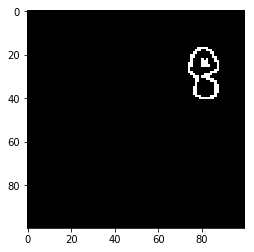

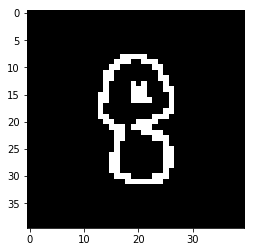

(40, 40)


In [158]:
def crop_img(img, square_size = 40):
    img = np.uint8(img)
    x_vals, y_vals, temp_length, temp_height = get_box_size(img)
    img =  img[y_vals[1]:y_vals[1]+temp_height + 1, x_vals[0]:x_vals[0]+temp_length + 1]
    img = cv2.copyMakeBorder(img,square_size//2-temp_height//2-1,square_size//2-temp_height//2-1,
                             square_size//2-temp_length//2-1,square_size//2-temp_length//2-1,cv2.BORDER_CONSTANT,value = 0)
    if img.shape[0] < 40:
        img = cv2.copyMakeBorder(img,1,0,0,0,cv2.BORDER_CONSTANT,value = 0)
    if img.shape[1] < 40:
        img = cv2.copyMakeBorder(img,0,0,1,0,cv2.BORDER_CONSTANT,value = 0)
    return img
img = preProcessImage(images[1122][1].reshape(100, 100))

plt.imshow(img, cmap = 'gray')
plt.show()
plt.imshow(crop_img(img), cmap = 'gray')
plt.show()
print(crop_img(img).shape)

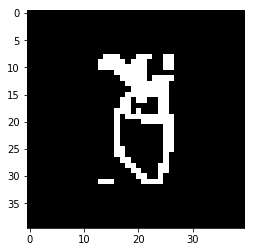

In [170]:
features_path = 'Datasets/train_images.npy'
labels_path = 'Datasets/train_labels.csv'
def pipeline(features_path, labels_path):
    images = np.load(features_path, encoding="bytes")
    labels = pd.read_csv(labels_path)
    labels = labels['Category'].values
    features = []
    for i in range(len(labels)):
        img = preProcessImage(images[i][1].reshape(100, 100))
        img = crop_img(img)
        features.append(img)
    return np.array(features)

new_features = pipeline(features_path, labels_path)
np.save('Datasets/processed_train_images.npy', new_features)
plt.imshow(new_features[49], cmap = 'gray')

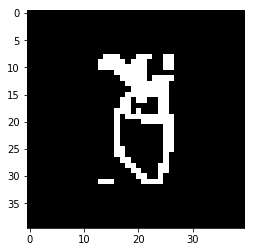

In [174]:
new_img_data = np.load('Datasets/processed_train_images.npy', encoding="bytes")
plt.imshow(new_img_data[49], cmap = 'gray')
new_features = new_features.reshape(10000, 1600)
np.save('Datasets/flat_processed_train_images.npy', new_features)

In [ ]:
######################################################
#########     END OF PREEEEEPROCESSING     ###########
######################################################

num_classes = len(labels['Category'].unique())
lb = LabelBinarizer()
lb.fit(labels['Category'].unique())
valueCounts = labels['Category'].value_counts()
